In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import re
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score #Compute Area Under the Curve (AUC) from prediction scores

import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')


In [4]:
print("There are {} observations and {} features in this dataset".format(train.shape[0],train.shape[1]))


There are 7613 observations and 5 features in this dataset


In [5]:
train.shape

(7613, 5)

In [6]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
train.text.head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [8]:
def cleaned(text):
    text = re.sub(r"\n","",text)
    text = text.lower()
    text = re.sub(r"\d","",text)        #Remove digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text) # remove non-ascii
    text = re.sub(r'[^\w\s]','',text) #Remove punctuation
    text = re.sub(r'http\S+|www.\S+', '', text) #Remove http
    return text

train['cleaned'] = train['text'].apply(lambda x : cleaned(x))


In [9]:
train.cleaned.head(10)

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
5    rockyfire update  california hwy  closed in bo...
6    flood disaster heavy rain causes flash floodin...
7    im on top of the hill and i can see a fire in ...
8    theres an emergency evacuation happening now i...
9     im afraid that the tornado is coming to our area
Name: cleaned, dtype: object

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   cleaned   7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


In [11]:
train = train[['cleaned', 'target']]

In [12]:
np.sum(train.duplicated())

618

In [13]:
train = train.drop_duplicates()

In [14]:
train.shape

(6995, 2)

In [15]:
train.target.value_counts()

0    4121
1    2874
Name: target, dtype: int64

In [16]:
train.head(10)

,cleaned,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1
5,rockyfire update california hwy closed in bo...,1
6,flood disaster heavy rain causes flash floodin...,1
7,im on top of the hill and i can see a fire in ...,1
8,theres an emergency evacuation happening now i...,1
9,im afraid that the tornado is coming to our area,1


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6995 entries, 0 to 7606
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cleaned  6995 non-null   object
 1   target   6995 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 163.9+ KB


In [18]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X = train['cleaned'].to_numpy()
y = train['target'].to_numpy()
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train = X.loc[train_index]
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y[train_index], y[test_index]


TRAIN: [4998 2201 6211 ... 3125 5080 3898] TEST: [2699 4527 6749 ... 2051 2655 6241]


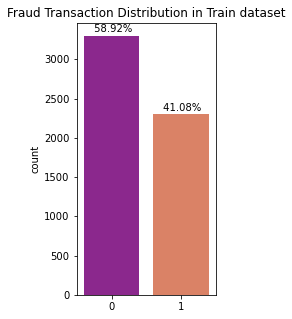

In [19]:
plt.figure(figsize=(2.5,5))
plt.title("Fraud Transaction Distribution in Train dataset")
p1 = sns.countplot(y_train, palette = 'plasma')

for p in p1.patches:
        p1.annotate('{:6.2f}%'.format(p.get_height()/len(y_train)*100), (p.get_x()+0.1, p.get_height()+50))
        
plt.show()

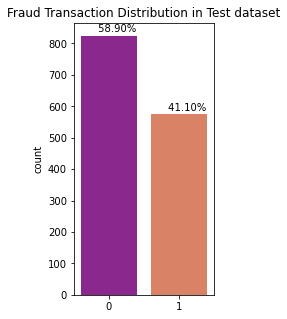

In [20]:
plt.figure(figsize=(2.5,5))
plt.title("Fraud Transaction Distribution in Test dataset")
p1 = sns.countplot(y_test, palette = 'plasma')

for p in p1.patches:
        p1.annotate('{:6.2f}%'.format(p.get_height()/len(y_test)*100), (p.get_x()+0.2, p.get_height()+12))
        
plt.show()

In [21]:

tweets_pipeline = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer())])

X_train_tranformed = tweets_pipeline.fit_transform(X_train)
X_test_tranformed = tweets_pipeline.transform(X_test)

In [22]:
classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'MNB': MultinomialNB(),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=300),
    'catboost': CatBoostClassifier(verbose=0)
        
}

In [23]:
no_classifiers = len(classifiers.keys())

from time import process_time 


def batch_classify(X_train_tranformed, y_train, X_test_tranformed, y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'Area Under Curve', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()  
        classifier.fit(X_train_tranformed, y_train)
        t_stop = process_time() 
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test_tranformed)
        
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Area Under Curve'] = roc_auc_score(y_test, y_predicted)
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results

In [24]:
df_results = batch_classify(X_train_tranformed, y_train,X_test_tranformed, y_test)
print(df_results.sort_values(by='Area Under Curve', ascending=False))

trained Logistic Regression in 0.25 s
trained Decision Tree in 2.24 s
trained k-Nearest Neighbors in 0.00 s
trained Linear SVM in 4.17 s
trained Gradient Boosting Classifier in 2.19 s
trained Random Forest in 10.38 s
trained RidgeClassifier in 0.04 s
trained AdaBoost in 1.46 s
trained MNB in 0.01 s
trained Perceptron in 0.02 s
trained xgboost in 11.02 s
trained catboost in 181.63 s
                      Classifier  Area Under Curve  Training time
3                     Linear SVM          0.773577       4.169639
0            Logistic Regression          0.766635       0.246441
8                            MNB          0.757180       0.005044
5                  Random Forest          0.756086      10.383487
6                RidgeClassifier          0.751015       0.037668
11                      catboost          0.738131     181.626021
10                       xgboost          0.735154      11.020022
2            k-Nearest Neighbors          0.724199       0.002043
7                    